In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import gc

In [2]:
with np.load('data/interim/kmers/kmer_matrix.npz') as data:
    kmers = data['kmers']
    kmer_order = data['kmer_order']
    genome_order = data['genome_order']

In [3]:
micsdf = joblib.load('data/interim/mic_class_dataframe2.pkl')
class_orders = joblib.load('data/interim/mic_class_order_dict2.pkl')

In [4]:
# TIO
tio_labels = class_orders['TIO']
tio_label_index = { k: v for v, k in enumerate(tio_labels) }
y_tio = np.array([ tio_label_index[m] if not pd.isna(m) else m for m in micsdf.loc[genome_order, 'TIO'] ])
labels, counts = np.unique(y_tio, return_counts=True)
ok = labels[counts >= 5]

mask = np.in1d(y_tio, ok) # Since Nan is not a label, this also filters invalid MICs
y_tio = y_tio[mask]
X_tio = kmers[mask,:]
tio_samples = genome_order[mask]
del kmers
del genome_order
del micsdf
del class_orders
gc.collect()
# %xdel kmers
# %xdel genome_order
# %xdel micsdf
# %xdel class_orders

45

In [5]:
# Test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tio, y_tio, test_size=0.2, random_state=36, stratify=y_tio)
del X_tio
del y_tio
gc.collect()

0

In [6]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([1., 2., 3., 4., 5., 6.]), array([ 404, 1046,   66,    6,   78,  205]))
(array([1., 2., 3., 4., 5., 6.]), array([101, 262,  16,   1,  20,  52]))


In [8]:
# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

fsel = SelectKBest(f_classif, k=500)
X_train_fs = fsel.fit_transform(X_train, y_train)
X_test_fs = fsel.transform(X_test)

import lightgbm as lgb
lgb_train = lgb.Dataset(X_train_fs, y_train)

/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 149082  195348  257056 ... 2008529 2008530 2008531] are constant.
  UserWarning)
/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [147]:
# Build LGB model

params = {
    'num_leaves': 20,
    'min_data_in_leaf': 75,
    #'max_bin': 200,
    'learning_rate': 0.02,
    'num_iterations': 350,
    'num_trees': 100,
    'metric': ('l2', 'auc'),
    'objective': 'multiclass',
    'num_threads': 12,
    'verbose': 0,
    'num_classes': 7,
    'boosting': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #'max_depth': 
}

evals_result = {}  # to record eval results for plotting

print('Start training...')
# train
lgbm = lgb.train(params,
    lgb_train)

print('complete')



Start training...


/home/matt/anaconda3/envs/phenores/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


complete


In [148]:
pr = lgbm.predict(X_test_fs)

In [149]:
cl = np.argmax(pr, 1)
sum(cl == y_test)/len(cl)

0.7411504424778761

In [189]:
params2 = {
    'task': 'train',
    'num_leaves': 20,
    'min_data_in_leaf': 75,
    #'max_bin': 200,
    'learning_rate': 0.02,
    #'num_iterations': 350,
    'num_trees': 1000,
    'metric': {'l2', 'auc'},
    'objective': 'quantile',
    'num_threads': 12,
    'verbose': 0,
    'boosting': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #'max_depth': 
}

lgbregm = lgb.train(params2,
        lgb_train,
        num_boost_round=350)
        #early_stopping_rounds=5)
y_pred = lgbregm.predict(X_test_fs)



In [191]:
sum((y_test < y_predh) & (y_test > y_predl))
# FAIL!!!!!

0

In [265]:
params2 = {
    'task': 'train',
    'num_leaves': 20,
    'min_data_in_leaf': 100,
    'max_bin': 200,
    'learning_rate': 0.02,
    'metric': {'poisson', 'auc'},
    'objective': 'regression',
    'num_threads': 12,
    'verbose': 0,
    'boosting': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #'max_depth': 
}

lgbregm = lgb.train(params2,
        lgb_train,
        num_boost_round=300)
        #early_stopping_rounds=5)
y_pred = lgbregm.predict(X_test_fs)



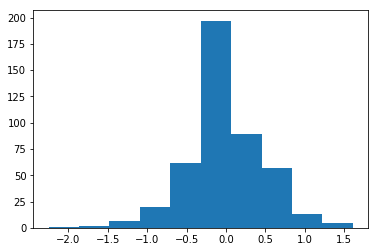

0.7234513274336283

In [266]:
import matplotlib.pyplot as plt
plt.hist(y_pred-y_test)
plt.show()

np.sum(np.abs(y_pred-y_test) < 0.5)/len(y_test)


In [278]:
params3 = {
    'task': 'train',
    'num_leaves': 20,
    'min_data_in_leaf': 100,
    'max_bin': 200,
    'learning_rate': 0.02,
    'metric': {'poisson', 'auc'},
    'objective': 'quantile',
    'alpha': 0.1,
    'num_threads': 12,
    'verbose': 0,
    'boosting': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    #'max_depth': 
}

lgbregm = lgb.train(params3,
        lgb_train,
        num_boost_round=300)
        #early_stopping_rounds=5)
y_pred_low = lgbregm.predict(X_test_fs)

params3['alpha'] = 0.1
lgbregm = lgb.train(params3,
        lgb_train,
        num_boost_round=300)
        #early_stopping_rounds=5)
y_pred_high = lgbregm.predict(X_test_fs)

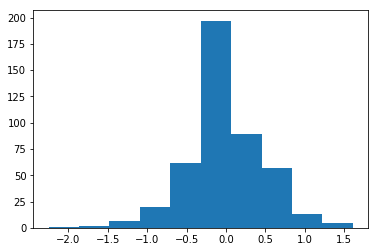

0.11946902654867257

In [279]:
import matplotlib.pyplot as plt
plt.hist(y_pred-y_test)
plt.show()

np.sum((y_test < y_pred_high))/len(y_test)
